## UC Berkeley Master of Information and Data Science Student Project
Course: W207 Applied Machine Learning<br>
Instructor: Cornelia Ilin

#### Group Members: Andre Gigena,  Jordan Lewis, and Dakota Potere-Ramos

### `Objectives`

- Demonstrate learned capabilities and understanding in machine learning skills and techniques
- Accurately predict room occupancy using non-intrusive sensors to aid first responders in locating occupants during emergencies.

### `Data`

[Source and data description](https://archive.ics.uci.edu/ml/datasets/Room+Occupancy+Estimation): The data comes from the UCI Machine learning repository from a study conducted at IIIT Hyderabad. Room occupancy numbers were collected as well as data from five different types of sensors: temperature, light, CO2, sound, and motion. While other devices such as video might yield better results for determining room occupancy, the sensors used in this study are non-intrusive so they protect the privacy of individuals which would make them more readily adoptable.

## Step 1: Import Packages

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
from joypy import joyplot
import seaborn as sns

# don't open new window for each plot
%matplotlib inline 

# For producing decision tree diagrams.
import IPython
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from graphviz import Source

# sklearn
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers


2023-04-05 15:01:46.144734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 15:01:46.965775: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-05 15:01:46.966077: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-05 15:01:48.698375: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Step 2: Define working directories

In [2]:
data_file = "data/raw/Occupancy_Estimation.csv"

## Step 3: Define classes

In [3]:
random_seed = 888

## Step 4: Define Functions

In [4]:
def split_data(X, y, split=(0.6, 0.2, 0.2), seed=random_seed):
    """
    Splits X/y into training, validation, and testing sets based on the
    specified split.

    Parameters
    ----------
    X : np.ndarray
    An array-like collection of sample points
    y : np.ndarray
    The class labels of the data, should match the length of data
    split : tuple
    The percentage allocation of training, validation, and test datasets

    Returns
    -------
    splits : tuple
    The training, validation, and test datasets with their labels
    """
    # Input checking
    if len(X) != len(y):
        raise ValueError(f"X and y lengths don't match ({len(X)} != {len(y)})")
    if len(split) != 3:
        raise ValueError("Invalid split, expected 3 percentages (training, validation, test)")
    if sum(split) != 1:
        raise ValueError(f"Invalid split {split}, percentages must sum to 1!")
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("X and y must be numpy arrays")
   
    # Initial split for testing data
    X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=split[2], random_state=seed, stratify=y)
    
    # Further split for validation data
    val_size = split[1] / (1 - split[2])
    X_train, X_val, y_train, y_val = train_test_split(
      X_train, y_train, test_size=val_size, random_state=seed, stratify=y_train)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
def get_parent_distribution(labels):
    ''' Computes parent distirbution
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    # Initialize counters for all labels to zero.
    label_probs = np.array([0.0 for i in range(max(np.unique(labels)) + 1)])

    # Iterate over labels in the training data and update counts.
    for label in labels:
        label_probs[label] += 1.0
    
    # Normalize to get a distribution.
    label_probs /= label_probs.sum()
    
    return label_probs

In [6]:
def entropy(distribution):
    ''' Computes the entropy index
    # param distribution: list containing distributions
    # return entropy index
    '''
    entropy_index = 0.0
    for probability in distribution:
        logprob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0: 
            logprob = np.log2(probability)
        entropy_index -= probability * logprob
        
    return entropy_index

In [7]:
def information_gain(data, labels, feature, threshold=0):
    ''' Computes information gain
    # param data: an array of featurized examples
    # param labels: an array of labels corresponding to the the data
    # param feature: the feature to use to split the data
    # param threshold: the feature value to use to split the data (the default threshold is good for binary features)
    '''
    # Get the initial entropy of the label distribution.
    initial_entropy = entropy(get_parent_distribution(labels))
    
    # subset0 will contain the labels for which the feature is 0 and
    # subset1 will contain the labels for which the feature is 1.
    subset0, subset1 = [], []
    for datum, label in zip(data, labels):
        if datum[feature] > threshold:
            subset1.append(label)
        else: 
            subset0.append(label)
    
    
    # Compute the entropy of each subset.
    subset0_entropy = entropy(get_parent_distribution(subset0))
    subset1_entropy = entropy(get_parent_distribution(subset1))
    
    # Compute the final entropy by weighting each subset's entropy according to its size.
    subset0_weight = 1.0 * len(subset0) / len(labels)
    subset1_weight = 1.0 * len(subset1) / len(labels)
    final_entropy = subset0_weight * subset0_entropy + subset1_weight * subset1_entropy
    
    # Finally, compute information gain as the difference between the initial and final entropy.
    return initial_entropy - final_entropy

In [8]:
def try_features_and_thresholds(data, labels):
    ''' Computes thresholds for each features and returns the threshold that optimized information gain
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    print('feature', 'best_threshold', 'best_IG', 'feature name')
    for feature in range(data.shape[1]):
        # Choose a set of thresholds between the min- and max-valued feature, ignoring the min and max themselves.
        thresholds = np.linspace(data[:,feature].min(), data[:,feature].max(), 20)[1:-1]

        # Try each threshold and keep track of the best one for this feature.
        best_threshold = 0
        best_IG = 0
        for threshold in thresholds:
            IG = information_gain(data, labels, feature, threshold)
            if IG > best_IG:
                best_IG = IG
                best_threshold = threshold

        # Show the best threshold and information gain for this feature.
        
        print ('%d %.3f %.3f %s' %(feature, best_threshold, best_IG, features[feature]))

In [9]:
def build_model(n_classes, learning_rate=0.01):
    """Builds a multi-class logistic regression model using Keras.

    Args:
        n_classes: Number of classes in the dataset
        learning_rate: The desired learning rate for SGD.

    Returns:
        model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'
    ))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])
    return model

In [10]:
def calculate_specificities(true_labels, predicted_labels, labels=[0, 1, 2, 3]):
    """
    Calculates the macro average specificity, micro average specificity and weighted average specificity
    from the given true and predicted labels

    Parameters
    ----------
    true_labels : np.ndarray
        An array-like collection of the true labels a model is trying to predict
    predicted_labels : np.ndarray
        An array-like collection of the predicted labels output from a model
    labels : list
        The set of unique class labels in the given classification problem
        Default: [0, 1, 2, 3]

    Returns
    -------
    macro_avg_specificity : float
        The macro average specificity for the model. The function calculates specificity for each class individually
        and takes the unweighted mean of all values    
    micro_avg_specificity : float
        The micro average specificity for the model. The function considers the total True Negatives (TN) and total False Positives (FP)
        amongst all classes and calculates specificity globally for the model
    weighted_avg_specificity: float
        The support weighted average specificity for the model. The function calculates specificity for each class individually
        and takes the weighted mean of all values based on the support of each class
    
    """

    # Calculate TN / TP / FN / FP
    mcm = sklearn.metrics.multilabel_confusion_matrix(true_labels, predicted_labels, labels=labels)
    TN = mcm[:,0,0]
    TP = mcm[:,1,1]
    FN = mcm[:,1,0]
    FP = mcm[:,0,1]

    # Calculate specificity for each class (TN/(TN+FP))
    specificity = TN / (TN+FP)
    print('\nspecificity for each class [0, 1, 2, 3]:', specificity)

    # calculate macro specificity
    macro_avg_specificity = round((sum(specificity)/len(specificity)),5)

    # calculate micro specificity
    micro_avg_specificity = round((sum(TN)/(sum(TN)+sum(FP))),5)
    
    support = np.unique(true_labels, return_counts=True)[1]
    weights = support/sum(support)
    weighted_avg_specificity = round(sum(specificity*weights),5)

    return macro_avg_specificity, micro_avg_specificity, weighted_avg_specificity

## Step 5: Read Data

In [11]:
df = pd.read_csv(data_file)
df.columns = ['Date','Time','Temp1', 'Temp2', 'Temp3', 'Temp4',
             'Light1', 'Light2', 'Light3', 'Light4', 'Sound1',
             'Sound2', 'Sound3', 'Sound4', 'CO2', 'CO2_Slope',
             'PIR1', 'PIR2', 'Occupancy_Count']
print('Shape of df occupancy:', df.shape)
print()
df.head()

Shape of df occupancy: (10129, 19)



,Date,Time,Temp1,Temp2,Temp3,Temp4,Light1,Light2,Light3,Light4,Sound1,Sound2,Sound3,Sound4,CO2,CO2_Slope,PIR1,PIR2,Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


# EDA

## Step 6: Data Preprocessing

### `Examine the balance of data`

The plot below shows the severe imbalance in the different values of `Occupancy_Count`

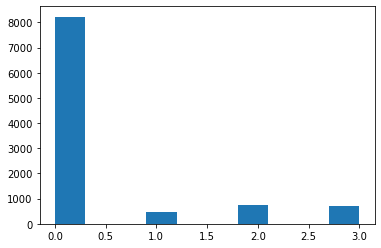

In [12]:
plt.hist(df['Occupancy_Count'])
plt.show()

#### `Explore reasons for data imbalance`

Convert the time and date to one date time value for easy exploration.

In [13]:
df["Time"] = pd.to_datetime(df["Date"] + df["Time"], format="%Y/%m/%d%H:%M:%S")

##### `Explore time imbalance`

In [14]:
min_occ = df[df['Occupancy_Count'] >= 1 ]['Time'].dt.time.min()
max_occ = df[df['Occupancy_Count'] >= 1 ]['Time'].dt.time.max()
print(f"The occupied times fall between {min_occ} and {max_occ}")

The occupied times fall between 10:49:41 and 19:51:46


Since the occupied times primarily fall between these times, we can explore what the balance would look like if only sampling between this time.

The histogram below shows that the occupancy counts are already much more balanced.

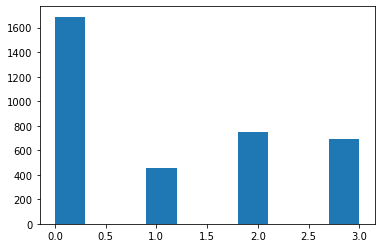

In [15]:
df_time_window = df[df['Time'].dt.time.between(min_occ, max_occ)]
plt.hist(df_time_window['Occupancy_Count'])
plt.show()

##### `Explore date imbalance`

This shows the distribution of what dates where occupancy counts is 0.

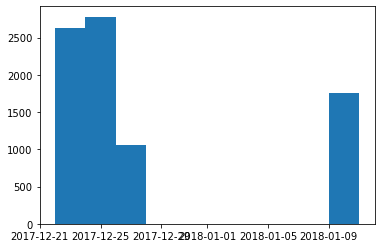

In [16]:
plt.hist(df[df["Occupancy_Count"] == 0]['Time'].dt.date)
plt.show()

Examining the distribution of non-occupied and occupied days. Occupied days only occur on the 22, 23, and 10th. So maybe sampling just these days is better as a first step.

In [17]:
df[(df["Occupancy_Count"] == 0) ]['Time'].dt.date.value_counts()

2017-12-23    1997
2017-12-25    1716
2017-12-24    1064
2017-12-26    1063
2018-01-11    1048
2018-01-10     703
2017-12-22     637
Name: Time, dtype: int64

In [18]:
df[(df["Occupancy_Count"] > 0)]['Time'].dt.date.value_counts()

2017-12-22    825
2017-12-23    782
2018-01-10    294
Name: Time, dtype: int64

### `labels and features`

In [19]:
labels = ['Occupancy_Count']

features = ['Temp1', 'Temp2', 'Temp3', 'Temp4',
            'Light1', 'Light2', 'Light3', 'Light4', 
            'Sound1', 'Sound2', 'Sound3', 'Sound4', 
            'CO2', 'CO2_Slope', 'PIR1', 'PIR2']

# ansamble data
df = df[labels+features]

# print data and shapes
print('Labels:', df['Occupancy_Count'].unique())
print('Features:', df.columns[1:])
print('Shape of data', df.shape)
df.head()

Labels: [1 2 3 0]
Features: Index(['Temp1', 'Temp2', 'Temp3', 'Temp4', 'Light1', 'Light2', 'Light3',
       'Light4', 'Sound1', 'Sound2', 'Sound3', 'Sound4', 'CO2', 'CO2_Slope',
       'PIR1', 'PIR2'],
      dtype='object')
Shape of data (10129, 17)


,Occupancy_Count,Temp1,Temp2,Temp3,Temp4,Light1,Light2,Light3,Light4,Sound1,Sound2,Sound3,Sound4,CO2,CO2_Slope,PIR1,PIR2
0,1,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0
1,1,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0
2,1,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0
3,1,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0
4,1,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0


### `split data into training and test`

In [20]:
# use data from occupied time window #
######################################
df = df_time_window

# define outcome #
##################
y = df['Occupancy_Count'].values

# define features #
###################
X = df[['Temp1', 'Temp2', 'Temp3', 'Temp4',
             'Light1', 'Light2', 'Light3', 'Light4', 'Sound1',
             'Sound2', 'Sound3', 'Sound4', 'CO2', 'CO2_Slope',
             'PIR1', 'PIR2']].values

# split #
#########
# set seed for consistent behavior
np.random.seed(random_seed)

split = (0.6, 0.2,0.2) #60% training 20% validation and 20% test
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data.
X, y = X[shuffle], y[shuffle]

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

print(f"Length of original dataset: {len(X)}")
print()
print(f"Length of X_train | y_train: {len(X_train)} | {len(y_train)}")
print(f"Length of X_val | y_val: {len(X_val)} | {len(y_val)}")
print(f"Length of X_test | y_test: {len(X_test)} | {len(y_test)}")
print()
print(f"Resulting split: ({len(X_train)/len(X):.2f}, {len(X_val)/len(X):.2f}, {len(X_test)/len(X):.2f})")


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns=['Occupancy_Count', 'Temp1', 'Temp2', 'Temp3', 'Temp4',
             'Light1', 'Light2', 'Light3', 'Light4', 'Sound1',
             'Sound2', 'Sound3', 'Sound4', 'CO2', 'CO2_Slope',
             'PIR1', 'PIR2']

Length of original dataset: 3590

Length of X_train | y_train: 2154 | 2154
Length of X_val | y_val: 718 | 718
Length of X_test | y_test: 718 | 718

Resulting split: (0.60, 0.20, 0.20)


### `feature scaling for optimal performance`

In [21]:
# standardize
sc_x = StandardScaler()

X_train_std = sc_x.fit(X_train).transform(X_train)
X_val_std = sc_x.fit(X_train).transform(X_val)
X_test_std = sc_x.fit(X_train).transform(X_test)

## Step 7: EDA

In [22]:
df_train.isna().sum()

Occupancy_Count    0
Temp1              0
Temp2              0
Temp3              0
Temp4              0
Light1             0
Light2             0
Light3             0
Light4             0
Sound1             0
Sound2             0
Sound3             0
Sound4             0
CO2                0
CO2_Slope          0
PIR1               0
PIR2               0
dtype: int64

#### `correlation matrix of feature and outcome variables`

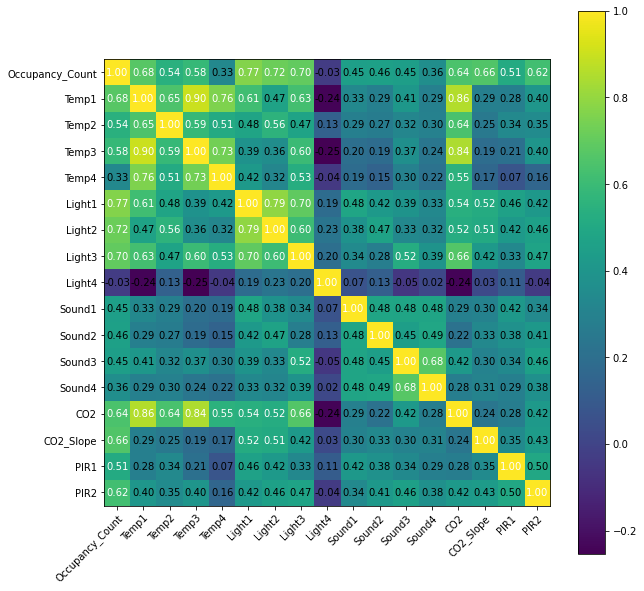

In [23]:
cm = df_train.corr().values
hm = heatmap(
    cm,
    row_names=df_train.columns,
    column_names=df_train.columns,
    figsize=(10, 10)
)

In [24]:
temp_avg = df_train[['Temp1','Temp2','Temp3','Temp4']].mean(axis = 1)
light_avg = df_train[['Light1', 'Light2', 'Light3', 'Light4']].mean(axis = 1)
sound_avg = df_train[['Sound1', 'Sound2', 'Sound3', 'Sound4']].mean(axis = 1)
df_train_avg = pd.DataFrame(df_train[['Occupancy_Count','CO2', 'CO2_Slope', 'PIR1', 'PIR2']])
df_train_avg.insert(1, 'sound_avg', sound_avg)
df_train_avg.insert(1, 'light_avg', light_avg)
df_train_avg.insert(1, 'temp_avg', temp_avg)
df_train_avg.head()

,Occupancy_Count,temp_avg,light_avg,sound_avg,CO2,CO2_Slope,PIR1,PIR2
0,1,26.1700,49.5,0.0675,475.0,1.096154,0.0,0.0
1,2,25.9700,87.0,0.2125,670.0,1.826923,0.0,1.0
2,1,24.9225,62.0,0.1700,390.0,0.519231,0.0,0.0
3,0,25.3300,35.5,0.1000,355.0,0.000000,0.0,0.0
4,0,26.3750,0.0,0.0625,1215.0,-0.126923,0.0,0.0


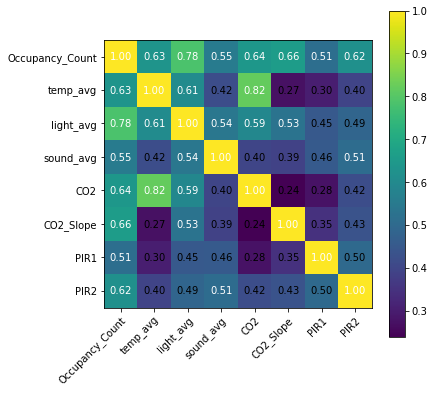

In [25]:
cm = df_train_avg.corr().values
hm = heatmap(
    cm,
    row_names=df_train_avg.columns,
    column_names=df_train_avg.columns,
    figsize=(6, 6)
)

#### `histogram of classes and features`

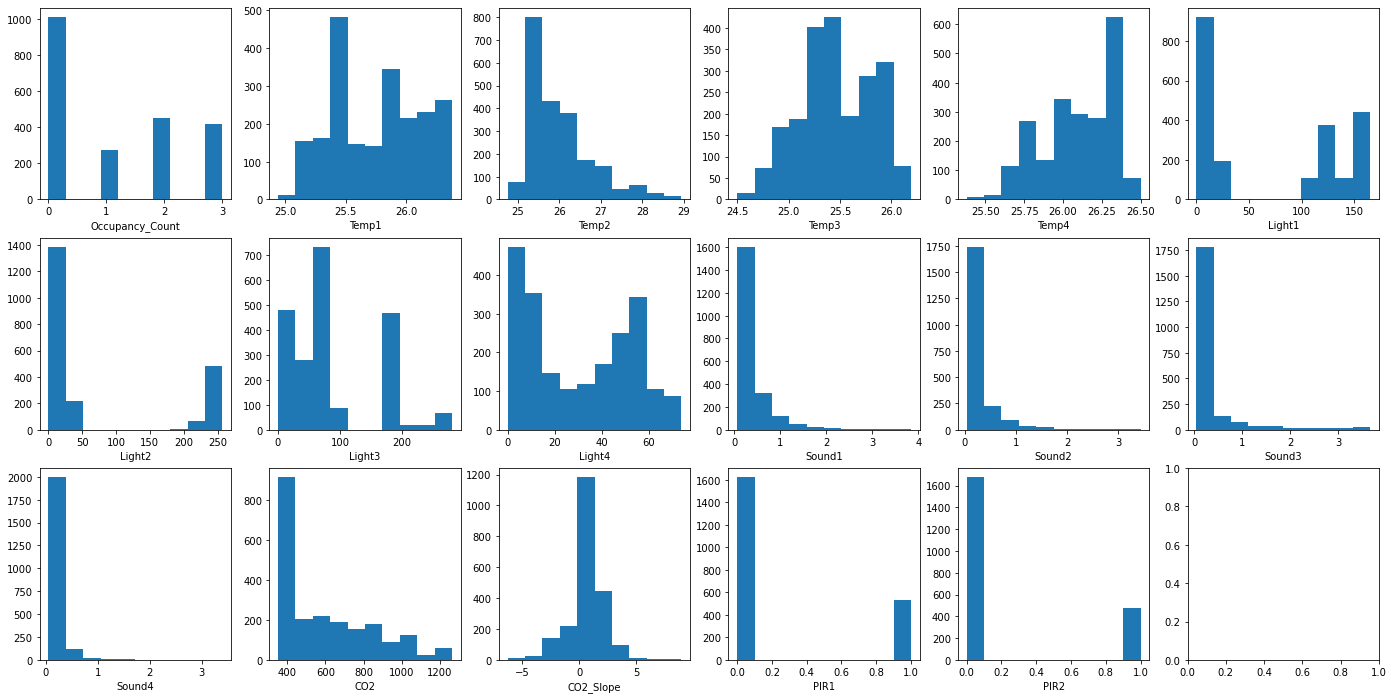

In [26]:
columns = ['Occupancy_Count', 'Temp1', 'Temp2', 'Temp3', 'Temp4',
             'Light1', 'Light2', 'Light3', 'Light4', 'Sound1',
             'Sound2', 'Sound3', 'Sound4', 'CO2', 'CO2_Slope',
             'PIR1', 'PIR2']
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
for idx, ax in enumerate(axes.flatten()):
    if idx >= len(columns):
        break
    # plot histogram
    ax.hist(df_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])

### Examining Sampling Techniques

Different sampling techniques have different strengths depending on the data. It is important to examine the distribution of data among the outcome variable `Occupancy_Count` to identify which sampling technique is best.

Some sampling techniques to consider:

    - Oversampling: Duplicating the values in the minority classes to achieve balance.
    - Class Weights: In the pre-processing stage, add weights to the data in the minority classes to add importance to these results.
    - SMOTE: (Synthetic Minority Oversampling Technique) has different methods of generating synthetic data through interpolation.
    - ADASYN: (Adaptive Synthetic) focuses on creating synthetic data where it is hard to classify.

#### Examining Data Distribution by Occupancy Count

Hard to see distribution of data with just a scatter plot since there are multiple points close together

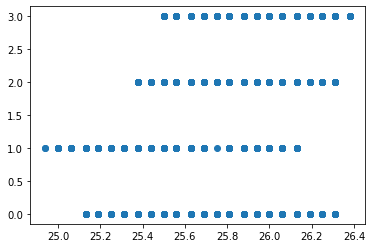

In [27]:
plt.scatter(df["Temp1"], df["Occupancy_Count"])

#### Multiple joyplots on one axis

While interesting, the data is too clustered to proceed with this technique, so splitting the data into individual joyplots will make it easier to examine the distribution.

<Figure size 432x288 with 0 Axes>

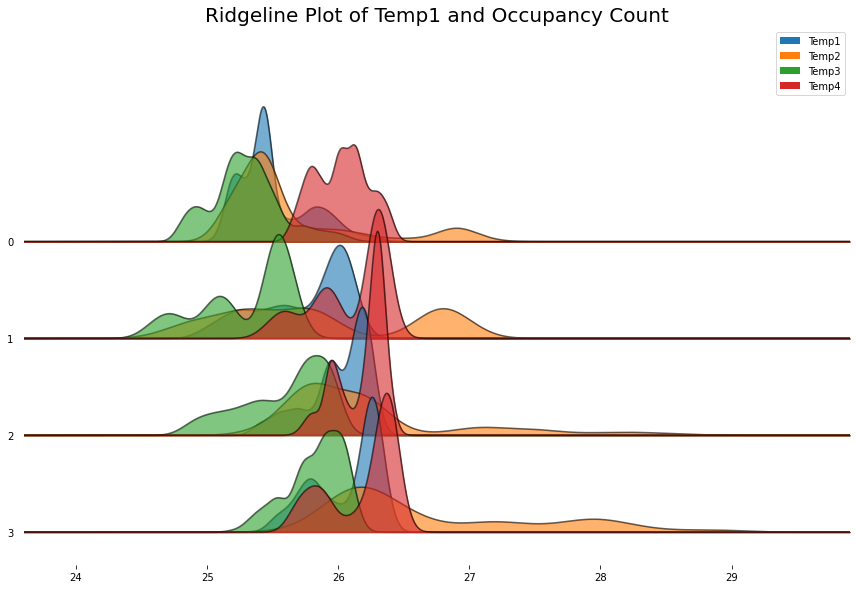

In [28]:
plt.figure()

joyplot(
    data=df[['Temp1', 'Temp2', 'Temp3', 'Temp4', 'Occupancy_Count']], 
    by='Occupancy_Count',
    figsize=(12, 8),
    alpha = 0.6,
    legend = True,
    overlap = 3
)
plt.title('Ridgeline Plot of Temp1 and Occupancy Count', fontsize=20)
plt.show()

#### One joyplot per axis

This reveals there is a lot of overlap for multiple variables. So maybe using ADASYN is a better option since it focuses on those hard to categorize boundary conditions.

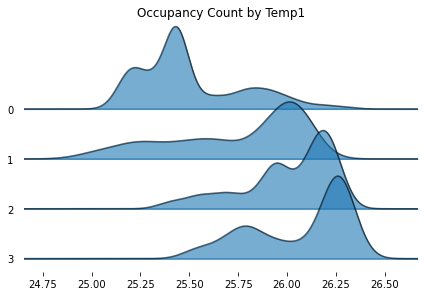

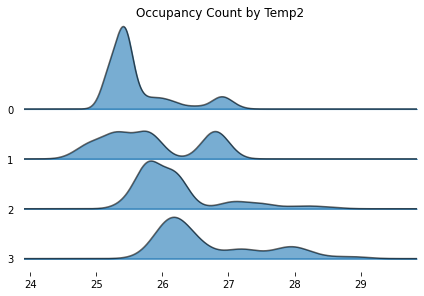

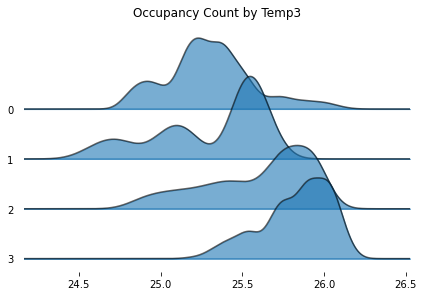

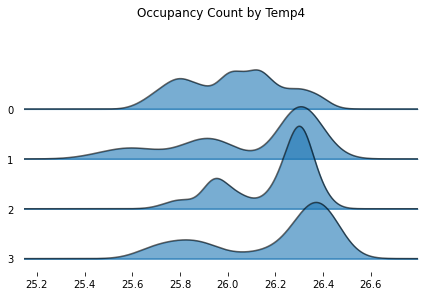

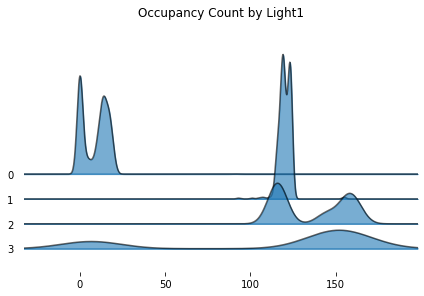

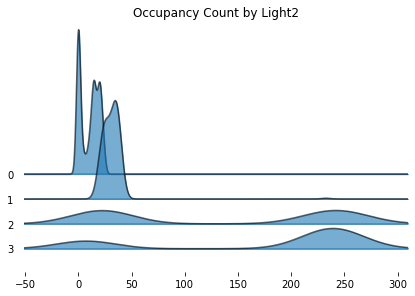

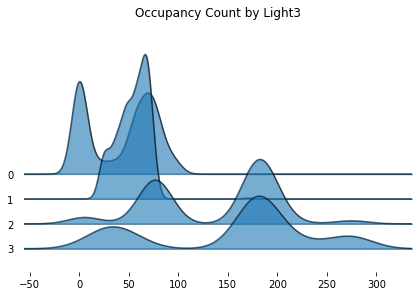

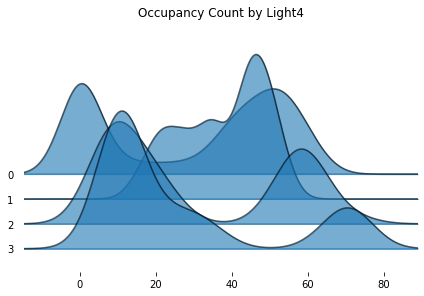

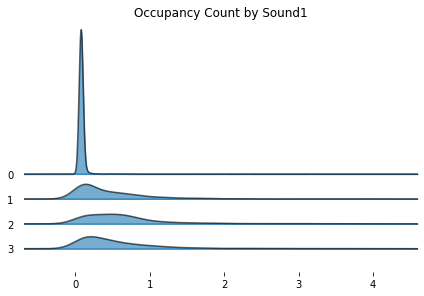

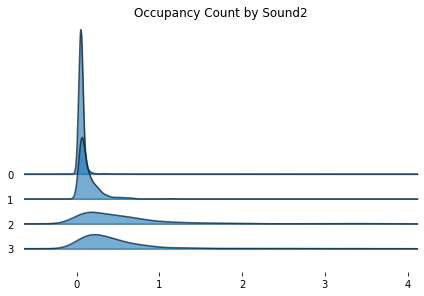

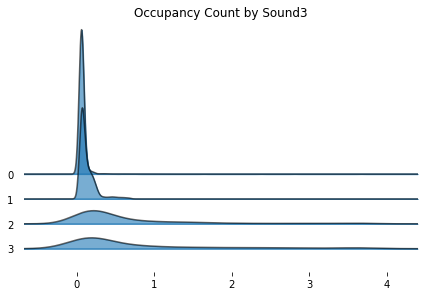

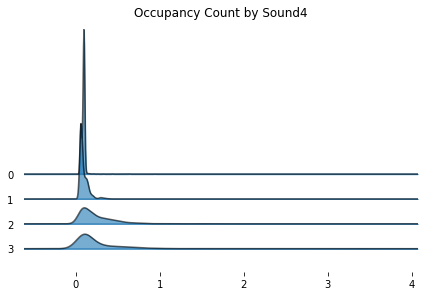

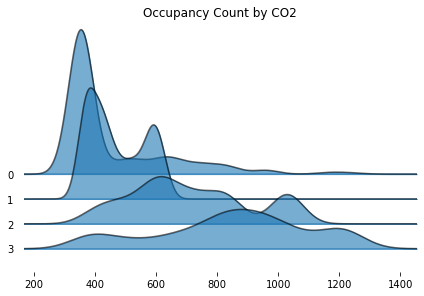

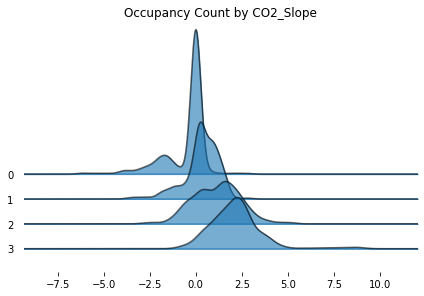

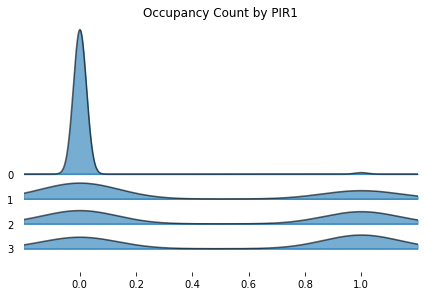

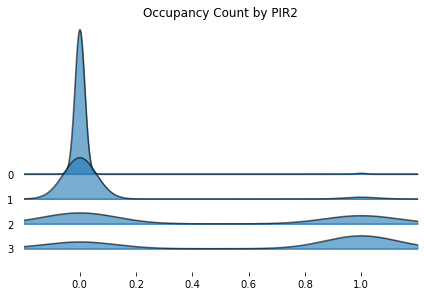

In [29]:

for idx in range(len(features)):
    # plot histogram
    if idx <= 3:
        joyplot(
            data=(df[[features[idx], "Occupancy_Count"]]), 
            by='Occupancy_Count',
            alpha = 0.6,
        )
    else: 
        joyplot(
            data=(df[[features[idx], "Occupancy_Count"]]), 
            by='Occupancy_Count',
            alpha = 0.6,
            overlap = 3
        )
    plt.title(f"Occupancy Count by {features[idx]}")
    # set xlabel
    #ax.set_xlabel(features[idx])

# Models

## Step 8.1: Decision Tree Classifier

#### Compute the Entropy of the parent data set

In [30]:
label_probs = get_parent_distribution(y_train)
print ('Parent distribution', label_probs)
# Compare the label entropy to a uniform distribution.
print ('Parent entropy:', entropy(label_probs))
print ('Uniform entropy:', entropy([1./4,1./4, 1./4, 1./4]))

Parent distribution [0.47028784 0.1281337  0.2084494  0.19312906]
Parent entropy: 1.8214105960196965
Uniform entropy: 2.0


### Compute the impurity of child nodes

In [31]:
np.unique(y_train)
# TODO

array([0, 1, 2, 3])

### Compute the information gain for each feature

In [32]:
######
# CHANGE NOTE:
# Change made to get_parent_entropy
# label_probs = np.array([0.0 for i in range(len(np.unique(labels)))]) 
# changed to 
# label_probs = np.array([0.0 for i in range(max(np.unique(labels)) + 1)])
# max was needed in case not all labels were present for each class

In [33]:
for feature in range(len(features)):
    IG = information_gain(X_train, y_train, feature, threshold = df_train[features[feature]].mean())
    print ('%d %.3f %s' %(feature, IG, features[feature]))

0 0.272 Temp1
1 0.264 Temp2
2 0.254 Temp3
3 0.063 Temp4
4 0.842 Light1
5 0.448 Light2
6 0.373 Light3
7 0.060 Light4
8 0.346 Sound1
9 0.342 Sound2
10 0.236 Sound3
11 0.255 Sound4
12 0.255 CO2
13 0.495 CO2_Slope
14 0.245 PIR1
15 0.322 PIR2


In [34]:
try_features_and_thresholds(X_train, y_train)

feature best_threshold best_IG feature name
0 25.471 0.363 Temp1
1 25.632 0.384 Temp2
2 25.656 0.330 Temp3
3 26.205 0.152 Temp4
4 26.053 0.842 Light1
5 40.579 0.448 Light2
6 103.158 0.471 Light3
7 3.895 0.192 Light4
8 0.259 0.403 Sound1
9 0.219 0.366 Sound2
10 0.231 0.294 Sound3
11 0.226 0.189 Sound4
12 398.158 0.316 CO2
13 0.141 0.538 CO2_Slope
14 0.053 0.245 PIR1
15 0.053 0.322 PIR2


Accuracy: 0.7938718662952646
Using a decision stump -- a tree with depth 2:
Features: ['Temp1', 'Temp2', 'Temp3', 'Temp4', 'Light1', 'Light2', 'Light3', 'Light4', 'Sound1', 'Sound2', 'Sound3', 'Sound4', 'CO2', 'CO2_Slope', 'PIR1', 'PIR2']
Feature importances: [0.         0.         0.         0.         0.65426089 0.
 0.21940243 0.         0.         0.         0.         0.
 0.         0.12633669 0.         0.        ]


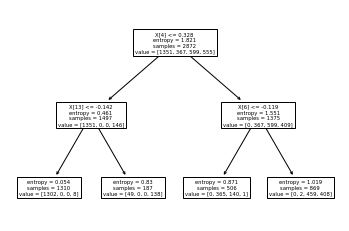

In [35]:
#Combine training and validation data for trees since they do not back-propogate
X_train_tree = np.concatenate((X_train_std, X_val_std))
y_train_tree = np.concatenate((y_train, y_val))

# Train a depth 2 decision tree classifier.
dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state = random_seed)
dt2.fit(X_train_tree, y_train_tree)
tree.plot_tree(dt2)
print ('Accuracy:', dt2.score(X_val_std, y_val))
print ('Using a decision stump -- a tree with depth 2:')
print('Features:', features)
print ('Feature importances:', dt2.feature_importances_)

2023-04-05 15:02:09.150829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-05 15:02:09.151101: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-05 15:02:09.151180: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-05 15:02:09.151247: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-05 15:02:09.151312: W tensorf

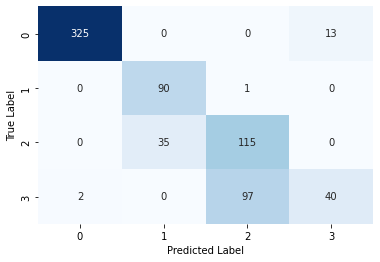

In [36]:
# Get predicted labels
y_pred = dt2.predict(X_val_std)
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=[0,1,2,3], yticklabels=[0,1,2,3], cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [37]:
macro_spec, micro_spec, weighted_spec = calculate_specificities(y_val, y_pred)


specificity for each class [0, 1, 2, 3]: [0.99473684 0.94417863 0.82746479 0.9775475 ]


Accuracy: 0.9373259052924791
Features: ['Temp1', 'Temp2', 'Temp3', 'Temp4', 'Light1', 'Light2', 'Light3', 'Light4', 'Sound1', 'Sound2', 'Sound3', 'Sound4', 'CO2', 'CO2_Slope', 'PIR1', 'PIR2']
Feature importances: [0.02643833 0.         0.         0.         0.5216927  0.16606704
 0.17494649 0.         0.01011746 0.         0.         0.
 0.         0.10073799 0.         0.        ]


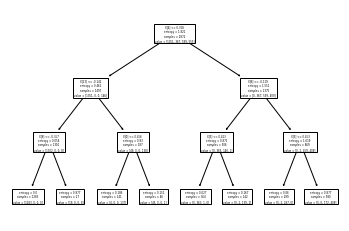

In [38]:
# Train a depth 3 decision tree classifier.
dt3 = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state = random_seed)
dt3.fit(X_train_tree, y_train_tree)
print ('Accuracy:', dt3.score(X_val_std, y_val))
tree.plot_tree(dt3);

print('Features:', features)
print ('Feature importances:', dt3.feature_importances_)
tree.export_graphviz(dt3, out_file = "tree.dot", feature_names = features)

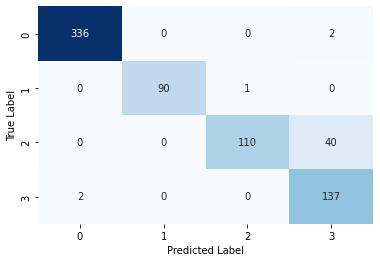

In [39]:
# Get predicted labels
y_pred = dt3.predict(X_val_std)
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=[0,1,2,3], yticklabels=[0,1,2,3], cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [40]:
macro_spec, micro_spec, weighted_spec = calculate_specificities(y_val, y_pred)


specificity for each class [0, 1, 2, 3]: [0.99473684 1.         0.99823944 0.92746114]


### Questions

- Using the data from the occupied time window lowered accuracy on a depth 3 tree from 96% to 92%.
- What depth should be used? Going from depth 3 - 4 with windowed data gives us an increase from 92% to 96%.
- Should standardized values be used for decision trees?
- How do you pass in validation data?

## Step 8.2: Boosted Decision Tree

In [41]:
adaclf = AdaBoostClassifier(base_estimator=dt2,
                            n_estimators=6,
                            learning_rate=0.1,
                            algorithm='SAMME.R',
                           random_state = random_seed)

adaclf.fit(X_train_tree, y_train_tree)
print ('Accuracy:', adaclf.score(X_val_std, y_val))

Accuracy: 0.9777158774373259


In [42]:
# hyperparameter_space = {'n_estimators':list(range(2, 102, 2)), 
#                         'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# from sklearn.model_selection import GridSearchCV

# gs = GridSearchCV(AdaBoostClassifier(base_estimator=dt2,
#                                      algorithm='SAMME.R',
#                                      random_state = random_seed),
#                   param_grid=hyperparameter_space, 
#                   scoring="accuracy", n_jobs=-1, cv=5)

# gs.fit(X_train_tree, y_train_tree)
# print("Optimal hyperparameter combination:", gs.best_params_)

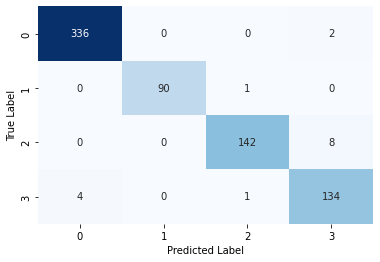

In [43]:
# Get predicted labels
y_pred = adaclf.predict(X_val_std)
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=[0,1,2,3], yticklabels=[0,1,2,3], cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [44]:
macro_spec, micro_spec, weighted_spec = calculate_specificities(y_val, y_pred)


specificity for each class [0, 1, 2, 3]: [0.98947368 1.         0.99647887 0.98272884]


### Questions:

- What boosted decision tree package should we use?
- Should we start the boosted tree from a stump? Accuracy is only 80% with best hyperparameters, but if started from `max_depth = 2` it is 98%

## Step 8.3: Logistic Regression

### Build and Train the Model

In [45]:
model = build_model(n_classes = 4, learning_rate = 0.01)

history = model.fit(
  x = X_train_std,
  y = y_train,
  epochs=100,
  batch_size=64,
  validation_data=(X_val_std, y_val),
  verbose=0)

history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,val_loss,val_accuracy
0,1.079528,0.577994,0.989288,0.583565
1,0.943694,0.640204,0.882213,0.658774
2,0.853263,0.688022,0.807015,0.675487
3,0.786500,0.692665,0.750019,0.682451
4,0.734171,0.701950,0.704059,0.701950
...,...,...,...,...
95,0.231496,0.952646,0.224227,0.951253
96,0.230538,0.954039,0.223259,0.951253
97,0.229442,0.953575,0.222299,0.951253
98,0.228539,0.954039,0.221350,0.951253


### Evaluate the Model

In [46]:
# Get predicted labels by taking the argmax -- the index with the largest probability from model.predict.
y_pred = np.argmax(model.predict(X_val_std), axis=-1)

23/23 [==============================] - 0s 1ms/step


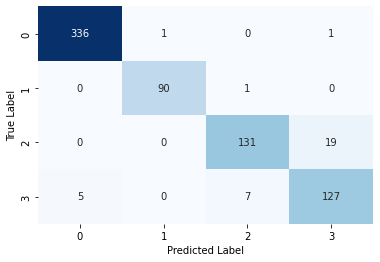

In [47]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=[0,1,2,3], yticklabels=[0,1,2,3], cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [48]:
print('Test, misclassified examples: %d' % (y_val != y_pred).sum())
error_test_tf = (y_val != y_pred).sum()/len(y_pred)
print('Test, prediction accuracy: %.3f'% (1-error_test_tf))

Test, misclassified examples: 34
Test, prediction accuracy: 0.953


### Examine Metric for each class

In [49]:
macro_spec, micro_spec, weighted_spec = calculate_specificities(y_val, y_pred)


specificity for each class [0, 1, 2, 3]: [0.98684211 0.9984051  0.98591549 0.96545769]


### Questions

- Should validation data also be standardized off of training data or based off of itself?
- How to decide number of epochs and batch size? Is it just computation time?

## Step 8.4 Deep Neural Network

In [50]:
tf.keras.backend.clear_session()
tf.random.set_seed(random_seed)

# first layer: input
input1 = tf.keras.layers.Input(shape=(len(features),), name='Input')
    
# second layer: dense (i.e., the nodes are fully connected)
input2 = tf.keras.layers.Dense(units=(len(features)/2), activation='relu', name='fc_1')(input1)
    
# third layer: dense (i.e., the nodes are fully connected)
input3 = tf.keras.layers.Dense(units=(len(features)/4), activation='relu', name='fc_2')(input2)
    

# fourth layer: dropout
# makes it so some of the nodes in a given layer don’t pass on their information to the next layer. 
# This helps with computation time (less parameters) and with overfitting.
#input4 = tf.keras.layers.Dropout(rate=0.3, name='Dropout')(input3)

#the fifth (and last) layer, which is the output layer
# this last layer sets the activation function to "None" in order to output the logits 
# logits = natural logarithm of the odds ratio
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
out = tf.keras.layers.Dense(units=4, activation=None, name='fc_4')(input3)

# instantiate the model
model = tf.keras.models.Model(inputs=input1, outputs=out)

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),  
              # ^ because our last layer does not apply sigmoid, by specifying from logits=True, the loss function applies the sigmoid function internally
              # ^ it's more efficient than doing it manually
              metrics=['accuracy']) # you can add other metrics here

In [52]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# create one hot encodings for labels
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=4)

history = model.fit(X_train_std, y_train_onehot,
                    epochs=100, 
                    validation_data=(X_val_std, y_val_onehot),
                    verbose = 0
)
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,val_loss,val_accuracy
0,1.254011,0.475859,1.087044,0.484680
1,1.019026,0.503714,0.938979,0.518106
2,0.891836,0.595636,0.834212,0.635098
3,0.781869,0.664810,0.729806,0.682451
4,0.678453,0.685701,0.639987,0.696379
...,...,...,...,...
95,0.030408,0.988394,0.044137,0.983287
96,0.030250,0.988858,0.044399,0.983287
97,0.030660,0.988858,0.044234,0.983287
98,0.031462,0.987465,0.044085,0.983287


In [53]:
y_pred = np.argmax(model.predict(X_val_std), axis=-1)

23/23 [==============================] - 0s 1ms/step


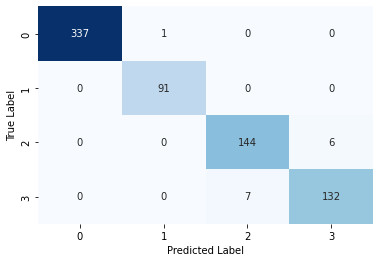

In [58]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, y_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=[0,1,2,3], yticklabels=[0,1,2,3], cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [54]:
macro_spec, micro_spec, weighted_spec = calculate_specificities(y_val, y_pred)


specificity for each class [0, 1, 2, 3]: [1.         0.9984051  0.98767606 0.98963731]


In [55]:
macro_spec

0.99393

In [56]:
micro_spec

0.9935

In [57]:
weighted_spec

0.99522